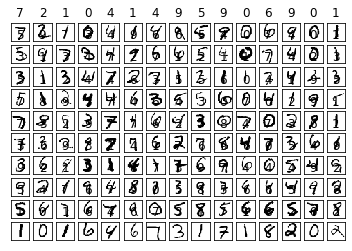

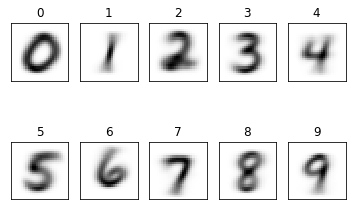

In [0]:
  import matplotlib.pyplot as plt
  import numpy as np

  file_data   = "/content/drive/My Drive/mnist.csv"
  handle_file = open(file_data, "r")
  data        = handle_file.readlines()
  handle_file.close()

  size_row    = 28    # height of the image
  size_col    = 28    # width of the image

  num_image   = len(data)
  count       = 0     # count for the number of images

  #
  # normalize the values of the input data to be [0, 1]
  #
  def normalize(data):

      data_normalized = (data - min(data)) / (max(data) - min(data))

      return(data_normalized)

  #
  # example of distance function between two vectors x and y
  #
  def distance(x, y):

      d = (x - y) ** 2
      s = np.sum(d)
      # r = np.sqrt(s)

      return(s)

  #
  # make a matrix each column of which represents an images in a vector form
  #
  list_image  = np.empty((size_row * size_col, num_image), dtype=float)
  list_label  = np.empty(num_image, dtype=int)

  for line in data:

      line_data   = line.split(',')
      label       = line_data[0]
      im_vector   = np.asfarray(line_data[1:])
      im_vector   = normalize(im_vector)

      list_label[count]       = label
      list_image[:, count]    = im_vector

      count += 1

  #
  # plot first 150 images out of 10,000 with their labels
  #
  f1 = plt.figure(1)

  for i in range(150):

      label       = list_label[i]
      im_vector   = list_image[:, i]
      im_matrix   = im_vector.reshape((size_row, size_col))

      plt.subplot(10, 15, i+1)
      plt.title(label)
      plt.imshow(im_matrix, cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)


  #plt.show()

  #
  # plot the average image of all the images for each digit
  #
  f2 = plt.figure(2)

  im_average  = np.zeros((size_row * size_col, 10), dtype=float)
  im_count    = np.zeros(10, dtype=int)

  for i in range(num_image):

      im_average[:, list_label[i]] += list_image[:, i]
      im_count[list_label[i]] += 1

  for i in range(10):

      im_average[:, i] /= im_count[i]

      plt.subplot(2, 5, i+1)
      plt.title(i)
      plt.imshow(im_average[:,i].reshape((size_row, size_col)), cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)

  plt.show()

In [0]:
from collections import OrderedDict


class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None

  def forward(self, x):
    self.x = x
    out = np.dot(x, self.W) + self.b

    return out
  
  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x.T, dout)
    self.db = np.sum(dout, axis = 0)

    return dx
  
class sigmoid:
  def __init__(self):
    self.out = None

  def forward(self,x):
      out = 1 / (1 + np.exp(-x))
      self.out = out

      return out

  def backward(self,dout):
      dx = dout * (1.0 - self.out) * self.out

      return dx

class ThreeLayerNet:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = np.power(2/(input_size+hidden_size1), 1/2) * np.random.randn(input_size, hidden_size1) # xavier
        self.params['b1'] = np.zeros(hidden_size1)
        self.params['W2'] = np.power(2/(hidden_size1+hidden_size2), 1/2) * np.random.randn(hidden_size1, hidden_size2)
        self.params['b2'] = np.zeros(hidden_size2)
        self.params['W3'] = np.power(2/(hidden_size2+output_size), 1/2) * np.random.randn(hidden_size2, output_size)
        self.params['b3'] = np.zeros(output_size)

        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['sigmoid1'] = sigmoid()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['sigmoid2'] = sigmoid()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['sigmoid3'] = sigmoid()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x
        
    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)

        t = np.int64(np.expand_dims(t, axis = 1))
        a = np.zeros((t.shape[0],10), dtype = int)
        for i in range(t.shape[0]):
          a[i,t[i]] = 1
        delta = 1e-7
        return -np.sum(a * np.log(y + delta) + (1-a) * np.log(1-y+delta)) / float(x.shape[0])
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x : 입력 데이터, t : 정답 레이블
        
    def gradient(self, x, t):
        # forward
        self.predict(x)

        # backward
        dout = 1   
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads

In [0]:
x_train = list_image[:, :6000].T
t_train = list_label[:6000]
x_test = list_image[:, 6000:].T
t_test = list_label[6000:]

In [0]:
network = ThreeLayerNet(input_size=784, hidden_size1=196, hidden_size2 = 49, output_size=10)
iters_num = 3000
train_size = x_train.shape[0]
learning_rate = 0.000001
train_loss_list = []
test_loss_list = []
train_acc_list = []
test_acc_list = []
decay = 0.001

for i in range(iters_num):
    
    grad = network.gradient(x_train, t_train) 
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        network.params[key] -= learning_rate * grad[key]
    
    train_loss = network.loss(x_train, t_train)  
    test_loss = network.loss(x_test, t_test)
    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    if i % 10 == 0:
        learning_rate = learning_rate * 1/(1 + decay)
        print(train_loss, test_loss, train_acc, test_acc)

# Plot the loss curve

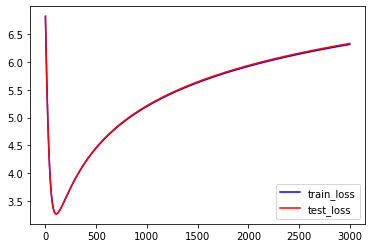

In [0]:
a = [i for i in range(3000)]
plt.plot(a, train_loss_list,label = 'train_loss', c = 'b')
plt.plot(a, test_loss_list,label = 'test_loss', c = 'r')
plt.legend()
plt.show()

# Plot the accuracy curve

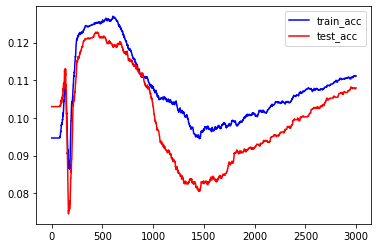

In [0]:
plt.plot(a, train_acc_list,label = 'train_acc', c = 'b')
plt.plot(a, test_acc_list,label = 'test_acc', c = 'r')
plt.legend()
plt.show()

# Plot the accuracy value

In [61]:
print("final train accuracy: {0}%".format(train_acc*100))

final train accuracy: 11.116666666666667%


In [62]:
print("final test accuracy: {0}%".format(test_acc*100))

final test accuracy: 10.8%


In [0]:
output = network.predict(x_test)
output = np.argmax(output, axis = 1)

In [0]:
correct_count = 0
incorrect_count = 0
image_idx = 0
correct_label = []
incorrect_label = []

while correct_count < 10 or incorrect_count < 10:
  if output[image_idx] == t_test[image_idx]:
    correct_count += 1
    correct_label.append(image_idx)
  else:
    incorrect_count += 1
    incorrect_label.append((image_idx, output[image_idx]))

  image_idx += 1


# 10 correctly classified testing images

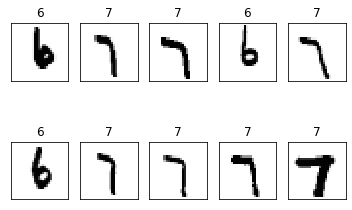

In [0]:
f1 = plt.figure(1)

for i in range(10):
      label       = t_test[correct_label[i]]
      im_vector   = x_test[correct_label[i],:]
      im_matrix   = im_vector.reshape((size_row, size_col))

      plt.subplot(2, 5, i+1)
      plt.title(label)
      plt.imshow(im_matrix, cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)
  

# 10 incorrectly classified testing images

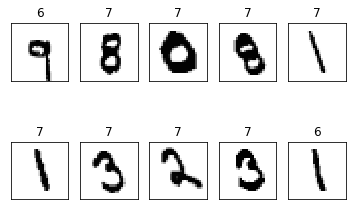

In [0]:
for i in range(10):
      label       = incorrect_label[i][1]
      im_vector   = x_test[incorrect_label[i][0],:]
      im_matrix   = im_vector.reshape((size_row, size_col))

      plt.subplot(2, 5, i+1)
      plt.title(label)
      plt.imshow(im_matrix, cmap='Greys', interpolation='None')

      frame   = plt.gca()
      frame.axes.get_xaxis().set_visible(False)
      frame.axes.get_yaxis().set_visible(False)